# Análise de Sensibilidade

![Análise de Sensibilidade](https://upload.wikimedia.org/wikipedia/commons/0/01/Sensitivity_scheme.jpg)
Este tipo de análise se propõe a medir a influencia de cada parâmetro do modelo sobre o resultado da simulação. A Sensibilidade do modelo à cada parâmetros é representada por um valor numérico chamado de *índice de sensibilidade*. estes índices pode ser de vários tipos:
* **Indices de primeira ordem** medem a contribuição de cada parâmetro individualmente para a variância da saída do modelo.$$S_i=\frac{V_i}{Var(Y)}$$
* **Indices de segunda ordem**  medem a contribuição de pares de parâmetros para a variância da saída do modelo.
* **Indices de ordem total** medem a contribuição de cada parâmetro incluindo todas as suas interações para a variância da saída do modelo.
$${\displaystyle S_{Ti}={\frac {E_{{\textbf {X}}_{\sim i}}\left(\operatorname {Var} _{X_{i}}(Y\mid \mathbf {X} _{\sim i})\right)}{\operatorname {Var} (Y)}}=1-{\frac {\operatorname {Var} _{{\textbf {X}}_{\sim i}}\left(E_{X_{i}}(Y\mid \mathbf {X} _{\sim i})\right)}{\operatorname {Var} (Y)}}}$$

Para realizarmos esta análise vamos precisar instalar duas bibliotecas: [salib](https://salib.readthedocs.io/en/latest/) e [epimodels](https://github.com/fccoelho/epimodels). Para instalá-los, basta ativar a shell do Sage:
```bash
sage -sh
```
e executar os seguintes comandos:
```
pip install salib
pip install epimodels
pip install seaborn
exit
```

Ou diretamente aqui no notebook:


In [4]:
!pip install -U salib epimodels seaborn

     |████████████████████████████████| 756 kB 3.5 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 292 kB 24.3 MB/s eta 0:00:01
     |████████████████████████████████| 81 kB 9.3 MB/s  eta 0:00:01
     |████████████████████████████████| 128 kB 24.3 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 4.3 MB/s  eta 0:00:01
  Using cached dill-0.3.4-py2.py3-none-any.whl (86 kB)
  Created wheel for epimodels: filename=epimodels-0.3.21-py2.py3-none-any.whl size=11186 sha256=2083ee0b8b2bba74f9ea8c8e4590a49b68854904b3c35826e1aa7803fd7a404d
  Stored in directory: /home/fccoelho/.cache/pip/wheels/f6/6c/5b/ac485cfee61a30f683fc06572642963fa4ce6e2063464d529b
Successfully built epimodels
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.1
    Uninstalling seaborn-0.11.1:
      Successfully uninstalled seaborn-0.11.1
You should c

In [9]:
%display typeset

In [1]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from epimodels.continuous import models as cm
import seaborn as sns
import numpy as np
import pandas as pd
import pylab as plt

## Escolhendo o Modelo
Vamos usar o Modelo SEIAHR apresentado no suplemento 2 e disponível na biblioteca epimodels.

In [2]:
my_model = cm.SEQIAHR()

In [3]:
my_model.parameters

OrderedDict([('chi', '$\\chi$'), ('phi', '$\\phi$'), ('beta', '$\\beta$'), ('rho', '$\\rho$'), ('delta', '$\\delta$'), ('gamma', '$\\gamma$'), ('alpha', '$\\alpha$'), ('mu', '$\\mu$'), ('p', '$p$'), ('q', '$q$'), ('r', '$r$')])

Vamos atribuir valores iniciais aos parâmetros do modelo

In [4]:
params = {
'chi': .3,
'phi': 0.012413633926076584,
'beta': 0.27272459855759813,
'rho': 0.2190519831830368,
'delta': 0.04168480042146949,
'gamma': 0.04,
'alpha':  0.3413355572047603,
'mu': 0.02359234606623134,
'p': 0.7693029079871165,
'q': 50,
'r': 55,
}
inits = [.99, 0, 1e-4, 0, 0, 0, 0, 0]

Durante a análise de sensibilidade vai ser necessário executar muitas vezes o modelo, então é interessante termos uma ideia de quanto tempo custa simulá-lo

In [5]:
%%timeit
# parms = dict(zip(params.keys(),param_values[3]))
my_model(inits=inits, trange = [0,200], totpop=1, params=params)
# max(my_model.traces['I'])

/home/fccoelho/Downloads/SageMath/local/lib/python3.9/site-packages/epimodels/continuous/models.py:195: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_model" failed type inference due to: non-precise type pyobject
During: typing of argument at /home/fccoelho/Downloads/SageMath/local/lib/python3.9/site-packages/epimodels/continuous/models.py (197)

File "../../../../Downloads/SageMath/local/lib/python3.9/site-packages/epimodels/continuous/models.py", line 197:
    def _model(self, t: float, y: list, params: dict) -> list:
        S, E, I, A, H, R, C, D = y
        ^

  @numba.jit
/home/fccoelho/Downloads/SageMath/local/lib/python3.9/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "_model" was compiled in object mode without forceobj=True.

File "../../../../Downloads/SageMath/local/lib/python3.9/site-packages/epimodels/continuous/models.py", line 196:
    @numba.jit
    def _model(self, t: float, y: list, 

95.8 ms ± 8.89 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


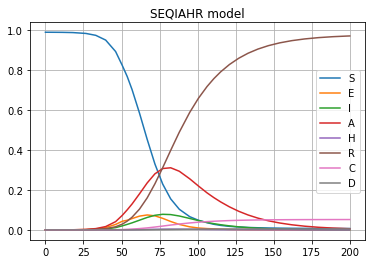

In [6]:
my_model.plot_traces(['I','A'])

## Definindo a análise

In [8]:
problem = {
    'num_vars': 11,
    'names': list(params.keys()),
    'bounds': [[0,.3],[0,1.],[0.1,2],[0.2,1],[0.01,1],[0.01,1],
              [0.01,1],[0.01,.7],[0.01,.7],[1,30],[1,12]]
}

## Gerando as amostras

In [13]:
param_values = saltelli.sample(problem, 1024)

In [14]:
param_values.shape

(24576, 11)

In [15]:
(8.9*24576)/1000

218.726400000000

## Rodando o Modelo
Para fazer a análise de sensibilidade precisamos selecionar um aspecto da saída do model, sobre o qual desejamos estudar a variância em resposta à varância dos parâmetros. Para este caso simples, vamos escolher o valor de pico de $I(t)$.

In [16]:
def eval_model(parametros):
    parms = dict(zip(params.keys(),parametros))
    mod = cm.SEQIAHR()
    mod(inits=inits, trange = [0,200], totpop=1, params=parms)
    Y = max(mod.traces['I'])
    return Y

Agora, basta executar uma simulação para cada conjunto de valores de parâmetros que amostramos.

In [21]:
# Y = np.zeros([param_values.shape[0]])
# for i, p in enumerate(param_values):
#     Y[i] = eval_model(p)

Para acelerar a execução dos cenários, vamos paralelizar a simulação do modelo

In [17]:
from multiprocessing import Pool

In [18]:
Po = Pool()
Y = Po.map(eval_model, param_values)

In [19]:
Po.close()

In [20]:
Si = sobol.analyze(problem, np.array(Y), print_to_console=False)

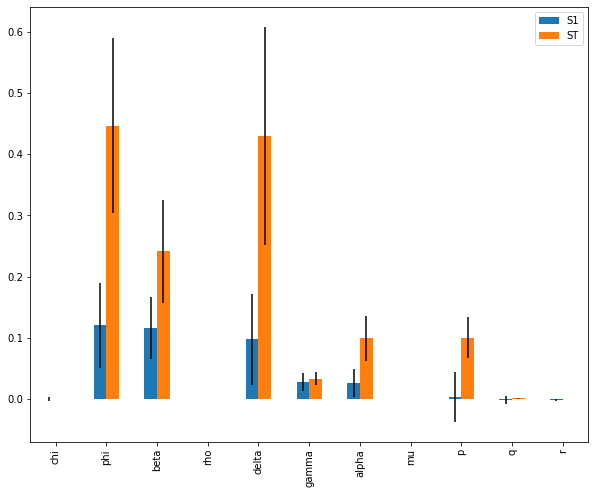

In [21]:
def plot_sobol(si,prob, order=1):
    Si_filter = {k:si[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(Si_filter, index=problem['names'][:-1])
    fig, ax = plt.subplots(1, figsize=(10,8))

    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]

    indices.plot.bar(yerr=err.values.T,ax=ax)
plot_sobol(Si,problem)

Para plotar os índices de segunda ordem, vamos usar uma outra abordagem para a visualização

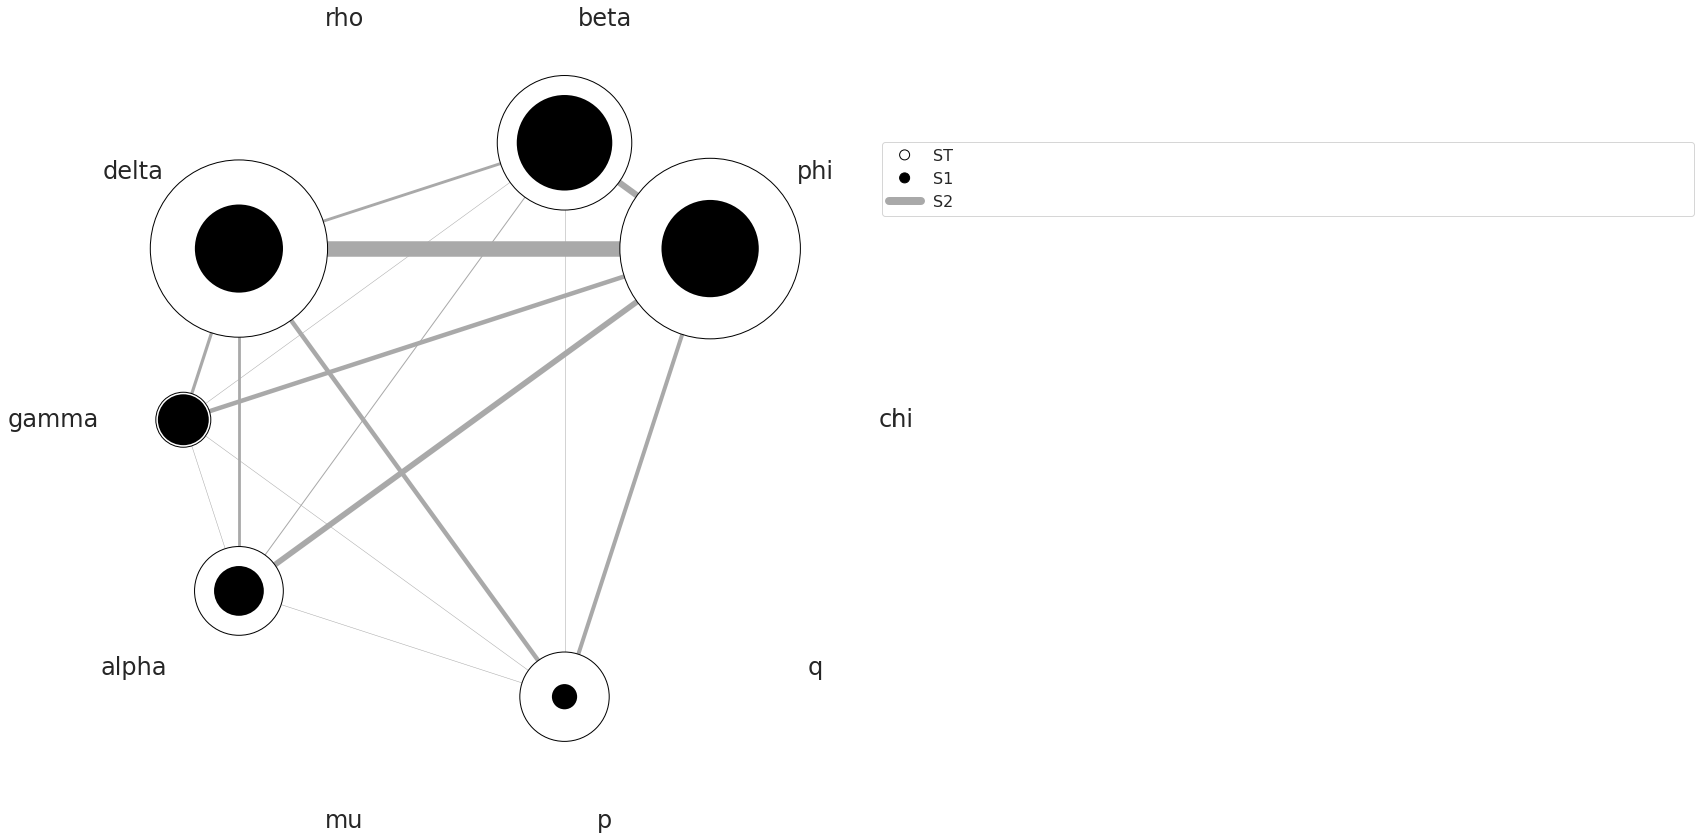

In [39]:
import itertools
from math import pi
from matplotlib.legend_handler import HandlerPatch


def normalize(x, xmin, xmax):
    return (x-xmin)/(xmax-xmin)


def plot_circles(ax, locs, names, max_s, stats, smax, smin, fc, ec, lw,
                 zorder):
    s = np.asarray([stats[name] for name in names])
    s = 0.01 + max_s * np.sqrt(normalize(s, smin, smax))

    fill = True
    for loc, name, si in zip(locs, names, s):
        if fc=='w':
            fill=False
        else:
            ec='none'

        x = np.cos(loc)
        y = np.sin(loc)

        circle = plt.Circle((x,y), radius=si, ec=ec, fc=fc, transform=ax.transData._b,
                            zorder=zorder, lw=lw, fill=True)
        ax.add_artist(circle)


def filter(sobol_indices, names, locs, criterion, threshold):
    if criterion in ['ST', 'S1', 'S2']:
        data = sobol_indices[criterion]
        data = np.abs(data)
        data = data.flatten() # flatten in case of S2
        # TODO:: remove nans

        filtered = ([(name, locs[i]) for i, name in enumerate(names[:-1]) if
                     data[i]>threshold])
        filtered_names, filtered_locs = zip(*filtered)
    elif criterion in ['ST_conf', 'S1_conf', 'S2_conf']:
        raise NotImplementedError
    else:
        raise ValueError('unknown value for criterion')

    return filtered_names, filtered_locs


def plot_sobol_indices(sobol_indices, criterion='ST', threshold=0.01):
    '''plot sobol indices on a radial plot

    Parameters
    ----------
    sobol_indices : dict
                    the return from SAlib
    criterion : {'ST', 'S1', 'S2', 'ST_conf', 'S1_conf', 'S2_conf'}, optional
    threshold : float
                only visualize variables with criterion larger than cutoff

    '''
    max_linewidth_s2 = 15#25*1.8
    max_s_radius = 0.3

    # prepare data
    # use the absolute values of all the indices
    #sobol_indices = {key:np.abs(stats) for key, stats in sobol_indices.items()}

    # dataframe with ST and S1
    sobol_stats = {key:sobol_indices[key] for key in ['ST', 'S1']}
    sobol_stats = pd.DataFrame(sobol_stats, index=problem['names'][:-1])

    smax = sobol_stats.max().max()
    smin = sobol_stats.min().min()

    # dataframe with s2
    s2 = pd.DataFrame(sobol_indices['S2'], index=problem['names'][:-1],
                      columns=problem['names'][:-1])
    s2[s2<0.0]=0. #Set negative values to 0 (artifact from small sample sizes)
    s2max = s2.max().max()
    s2min = s2.min().min()

    names = problem['names'][:-1]
    n = len(names)
    ticklocs = np.linspace(0, 2*pi, n)
    locs = ticklocs[0:-1]

    filtered_names, filtered_locs = filter(sobol_indices, names, locs,
                                           criterion, threshold)

    # setup figure
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, polar=True)
    ax.grid(False)
    ax.spines['polar'].set_visible(False)
    ax.set_xticks(ticklocs)

    ax.set_xticklabels(names, fontsize=24)
    ax.set_yticklabels([])
    ax.set_ylim(top=1.4)
    legend(ax)

    # plot ST
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['ST'], smax, smin, 'w', 'k', 1, 9)

    # plot S1
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['S1'], smax, smin, 'k', 'k', 1, 10)

    # plot S2
    for name1, name2 in itertools.combinations(zip(filtered_names, filtered_locs), 2):
        name1, loc1 = name1
        name2, loc2 = name2

        weight = s2.loc[name1, name2]
        lw = 0.5+max_linewidth_s2*normalize(weight, s2min, s2max)
        ax.plot([loc1, loc2], [1,1], c='darkgray', lw=lw, zorder=1)

    return fig



class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = plt.Circle(xy=center, radius=orig_handle.radius)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

def legend(ax):
    some_identifiers = [plt.Circle((0,0), radius=5, color='k', fill=False, lw=1),
                        plt.Circle((0,0), radius=5, color='k', fill=True),
                        plt.Line2D([0,0.5], [0,0.5], lw=8, color='darkgray')]
    ax.legend(some_identifiers, ['ST', 'S1', 'S2'],
              loc=(1,0.75), borderaxespad=0.1, mode='expand', fontsize=16,
              handler_map={plt.Circle: HandlerCircle()})


sns.set_style('whitegrid')
fig = plot_sobol_indices(Si, criterion='ST', threshold=0.005)